<a href="https://colab.research.google.com/github/ssunsonic/ML_Project/blob/main/Image_Preprocessing_Modeling_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Muffin vs Chihuahua CNN Final

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from PIL import Image
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

Moved all test images into train folder since we can just split them into train and test anyway

In [4]:
#destiny = '/content/drive/MyDrive/Colab Notebooks/ECS171/images/'
destiny = '/content/drive/MyDrive/ECS_171/ML_Project/images/'
dataset = tf.keras.utils.image_dataset_from_directory(destiny)

Found 5917 files belonging to 2 classes.


In [5]:
# dataset_name = dataset
class_names = dataset.class_names
print(class_names)

['test', 'train']


## Split into Train/Validation

In [6]:
ds_train = tf.keras.utils.image_dataset_from_directory(destiny,
            validation_split=0.2, subset = 'training', seed = 1)
ds_val = tf.keras.utils.image_dataset_from_directory(destiny,
            validation_split=0.2, subset = 'validation', seed = 1)

Found 5917 files belonging to 2 classes.
Using 4734 files for training.
Found 5917 files belonging to 2 classes.
Using 1183 files for validation.


In [7]:
# observing class split in training set
classes = []

for images, labels in ds_train.map(lambda x, y: (x, y)):
  # print(labels)
  classes.append(labels)
classes = np.concatenate(classes)
classes = pd.DataFrame(classes)
classes.value_counts()

1    3784
0     950
dtype: int64

In [8]:
# observing class split in test set
test = []

for images, labels in ds_val.map(lambda x, y: (x, y)):
  # print(labels)
  test.append(labels)
test = np.concatenate(test)
test = pd.DataFrame(test)
test.value_counts()

1    949
0    234
dtype: int64

There is a slight class imbalance in the training set above. The difference isn't too large, however, such that a decision to resample should be considered in my opinion.

## Image Resizing

In [9]:
# size of images we want to resize to
size = (50,50)

In [10]:
# resize all images
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_val = ds_val.map(lambda image, label: (tf.image.resize(image, size), label))

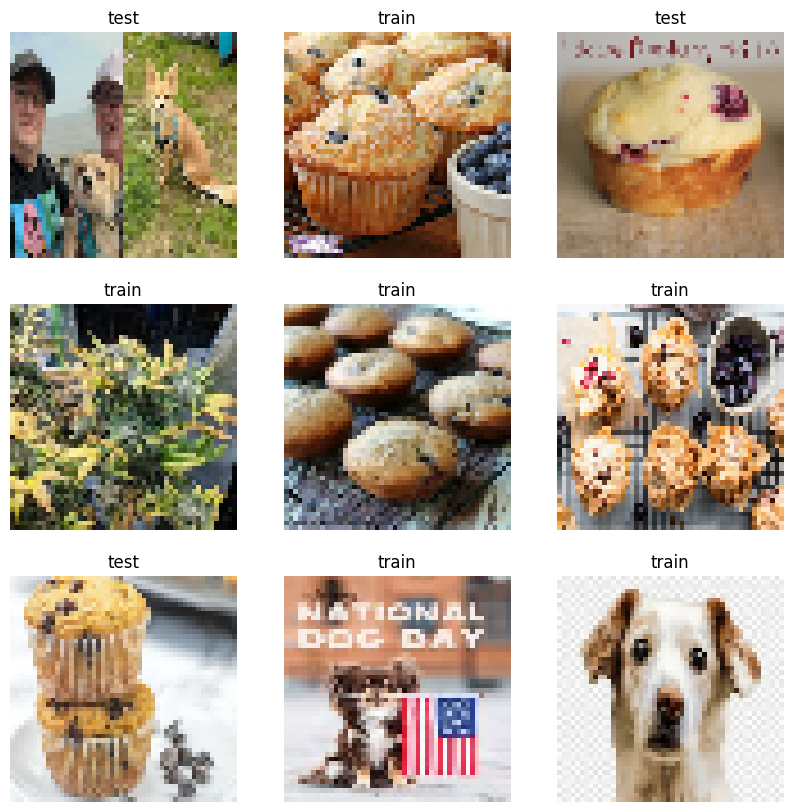

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  # display 9 resized images
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Greyscaling

In [12]:
ds_train = ds_train.map(lambda image, label: (tf.image.rgb_to_grayscale(image), label))
ds_val = ds_val.map(lambda image, label: (tf.image.rgb_to_grayscale(image), label))

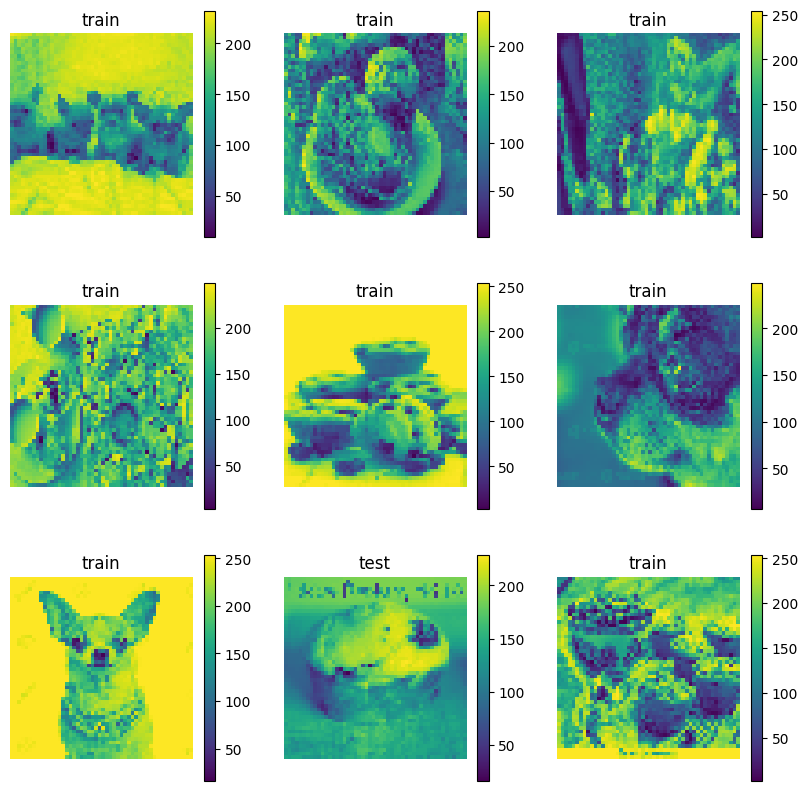

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.colorbar()

## Modeling

### CNN Keras Model 1


In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.losses import binary_crossentropy


model = Sequential()
# grayscaled images only have one channel not 3 for typical RGB
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

# compile and fit model
model.compile(optimizer = 'adam', loss = binary_crossentropy, metrics = ['accuracy'])
hist = model.fit(ds_train, validation_data = ds_val, epochs = 10, batch_size = 10000)

Epoch 1/10
148/148 [==============================] - 60s 373ms/step - loss: 1.0524 - accuracy: 0.7765 - val_loss: 0.5166 - val_accuracy: 0.8022
Epoch 2/10
148/148 [==============================] - 58s 380ms/step - loss: 0.5096 - accuracy: 0.7991 - val_loss: 0.5154 - val_accuracy: 0.8005
Epoch 3/10
148/148 [==============================] - 53s 347ms/step - loss: 0.5082 - accuracy: 0.7991 - val_loss: 0.5200 - val_accuracy: 0.7971
Epoch 4/10
148/148 [==============================] - 56s 371ms/step - loss: 0.4909 - accuracy: 0.8010 - val_loss: 0.5246 - val_accuracy: 0.7963
Epoch 5/10
148/148 [==============================] - 56s 372ms/step - loss: 0.4841 - accuracy: 0.8052 - val_loss: 0.5359 - val_accuracy: 0.7988
Epoch 6/10
148/148 [==============================] - 53s 348ms/step - loss: 0.4707 - accuracy: 0.8078 - val_loss: 0.5356 - val_accuracy: 0.7946
Epoch 7/10
148/148 [==============================] - 53s 345ms/step - loss: 0.4655 - accuracy: 0.8069 - val_loss: 0.5482 - val_ac

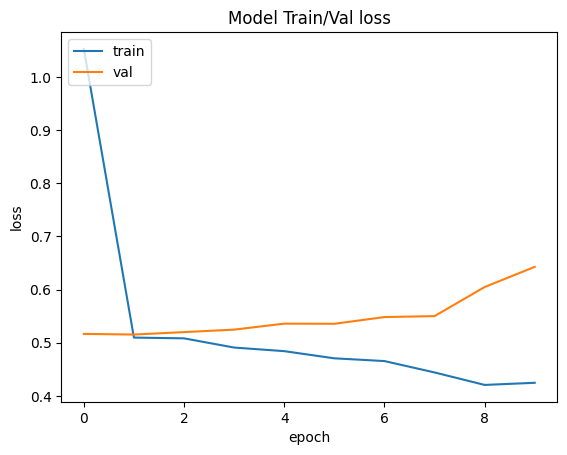

In [41]:
# error graph of first model

plt.plot(hist.history['loss'])
plt.plot(hist
.history['val_loss'])
plt.title('Model Train/Val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Commented out model above due to overfitting while fitting. Tested another model below with less convolutional layers for less complexity

In [42]:
# check accuracy for Model 1
test_loss, test_acc = model.evaluate(ds_val, verbose=2)

37/37 - 7s - loss: 0.6426 - accuracy: 0.7912 - 7s/epoch - 191ms/step


### CNN Model 2

In [43]:
model = Sequential()
# grayscaled images only have one channel not 3 for typical RGB
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [44]:
from keras.losses import binary_crossentropy
# compile model
model.compile(optimizer = 'adam', loss = binary_crossentropy, metrics = ['accuracy'])

In [45]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 11, 11, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 3872)              0         
                                                                 
 dense_16 (Dense)            (None, 32)               

Observe the images in every layer

In [46]:
layer_names = []

for layer in model.layers[:4]:
  layer_names.append(layer.name)
print(layer_names)

['conv2d_23', 'max_pooling2d_17', 'conv2d_24', 'max_pooling2d_18']


In [47]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(ds_train)

148/148 [==============================] - 33s 215ms/step


Observe Images In First Activation Layer

(4734, 48, 48, 32)


<ipython-input-48-53118c29512f>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.matshow(first_layer_activation[0, :, :, i], cmap ='viridis')


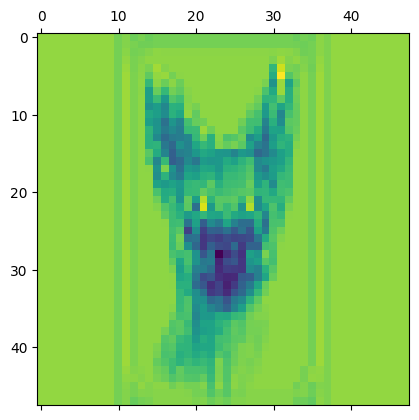

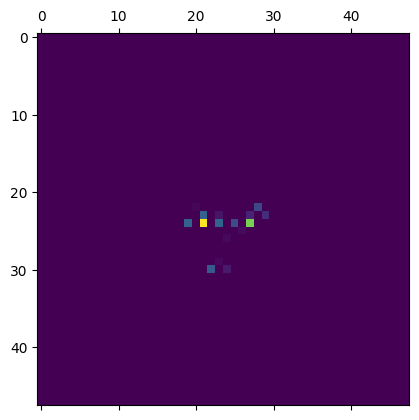

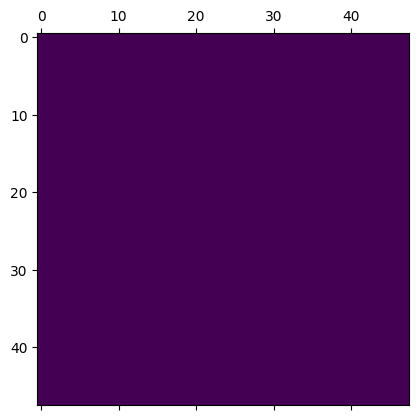

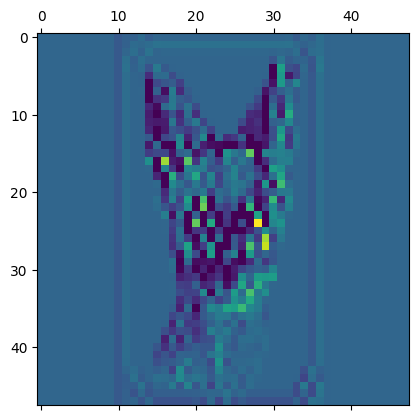

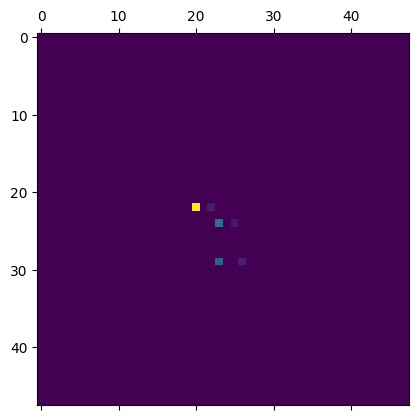

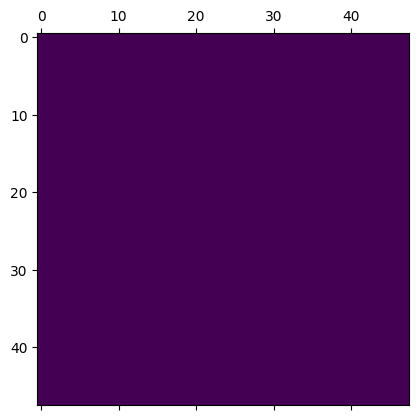

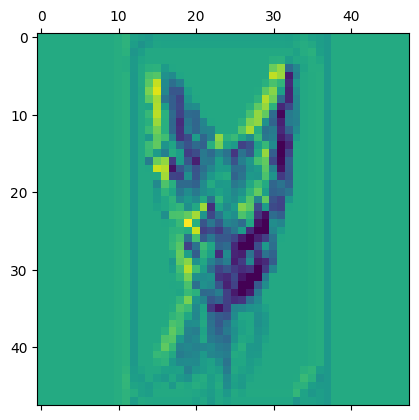

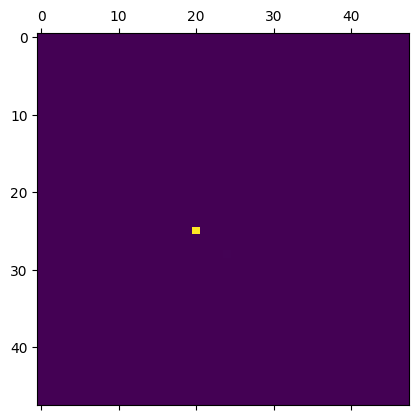

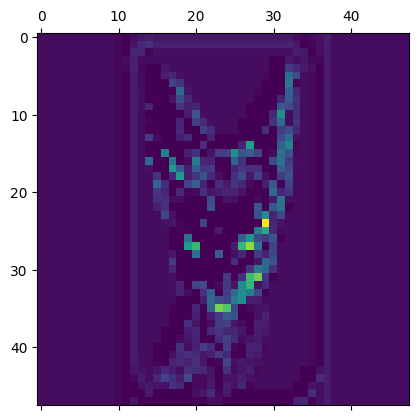

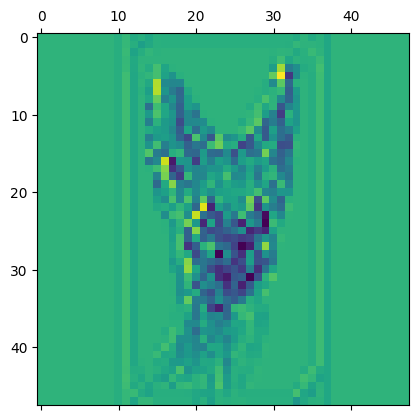

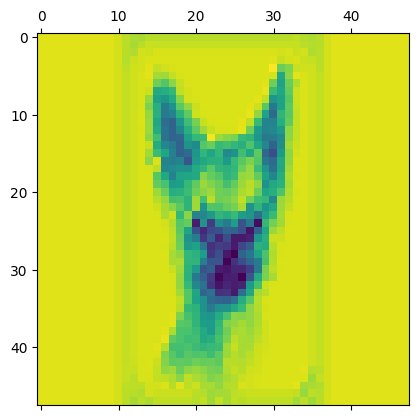

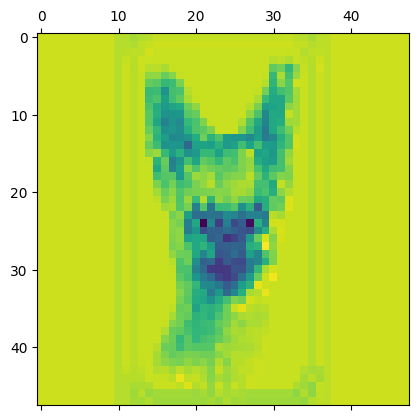

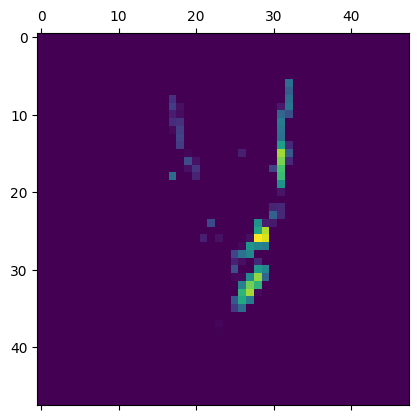

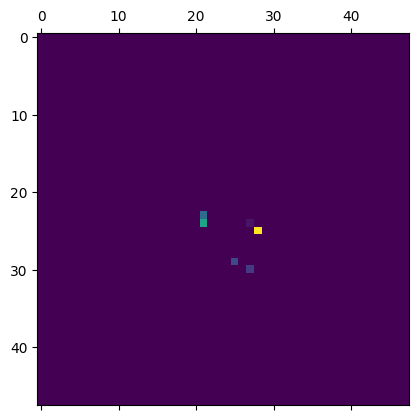

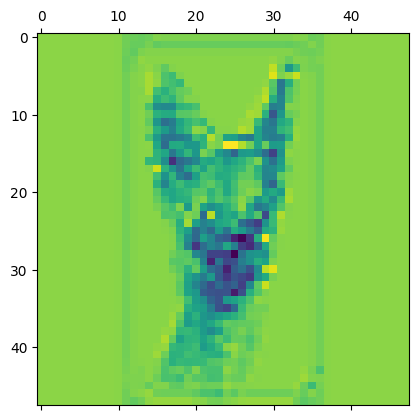

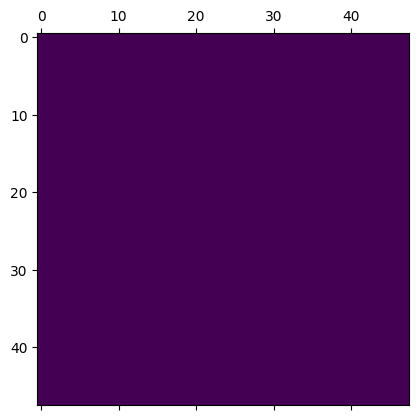

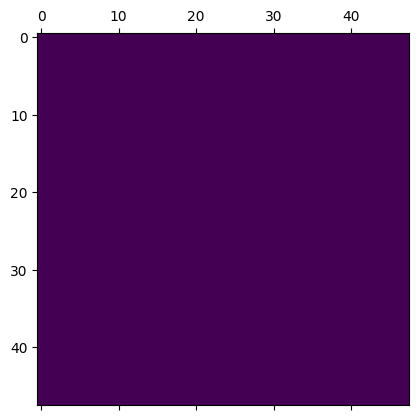

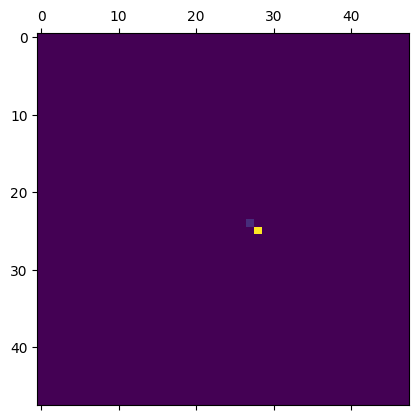

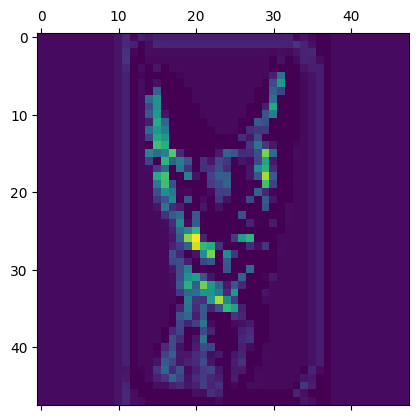

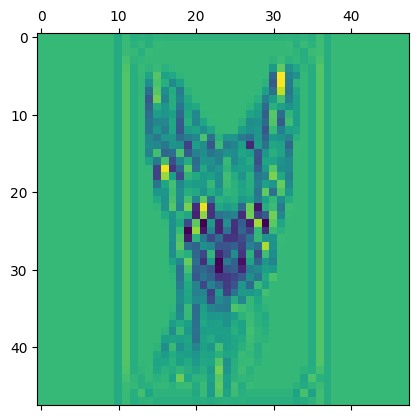

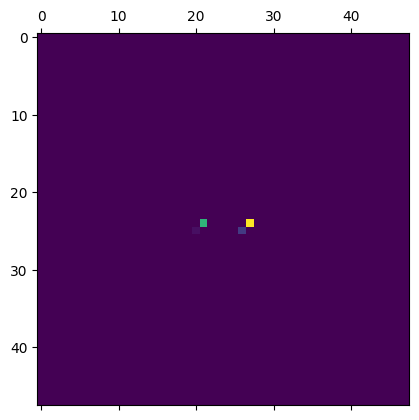

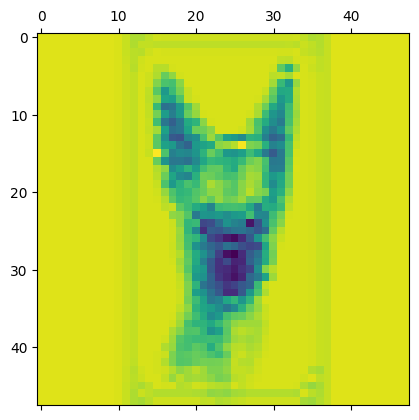

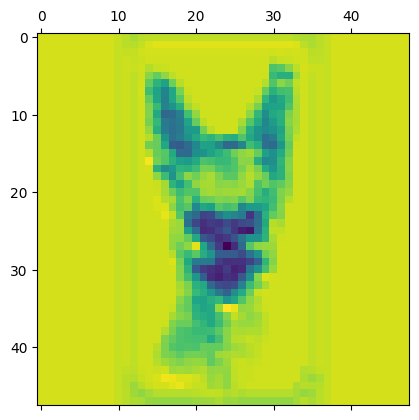

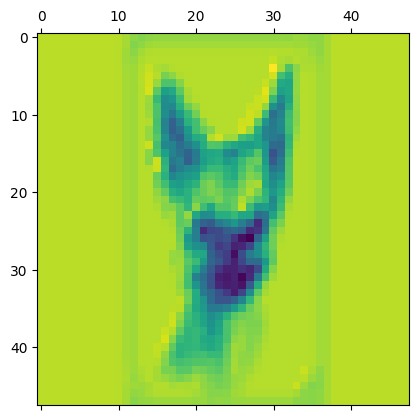

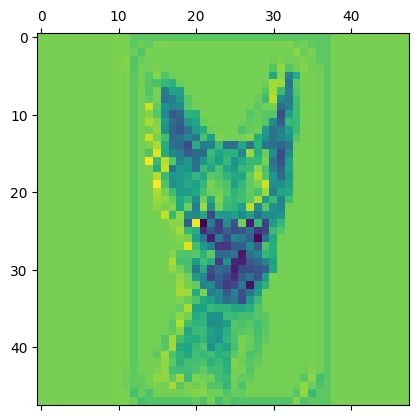

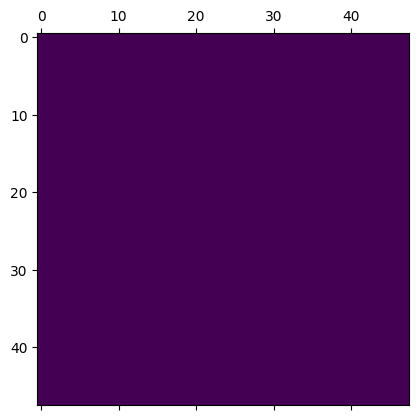

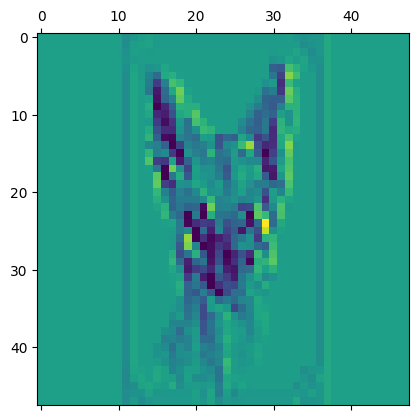

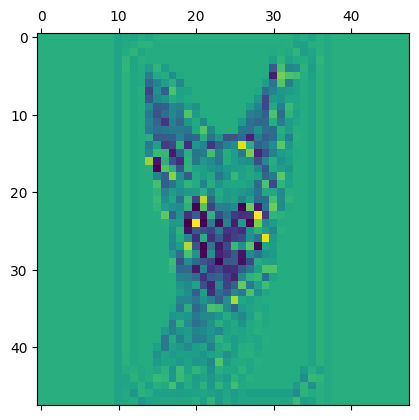

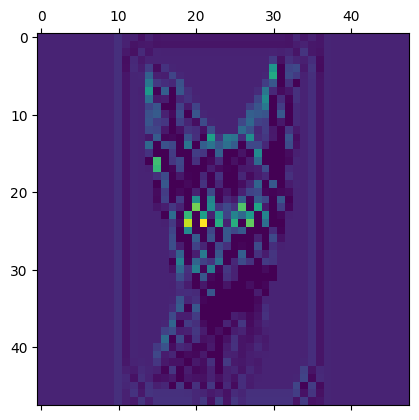

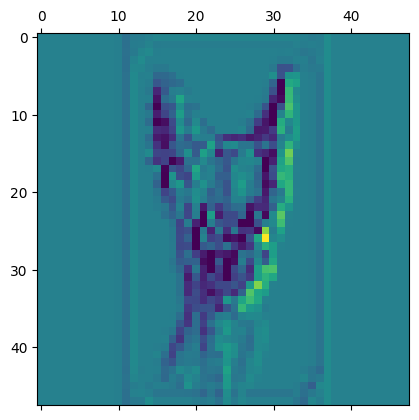

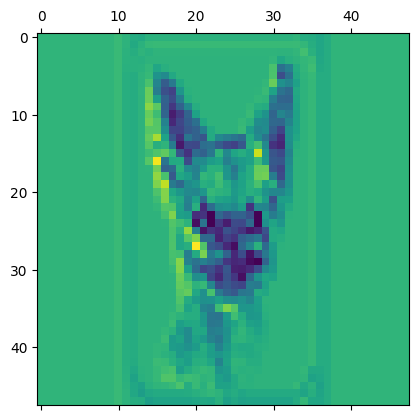

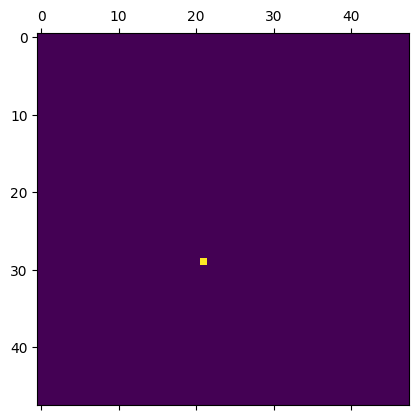

In [48]:
# # Getting Activations of first layer
first_layer_activation = activations[0]

# # shape of first layer activation
print(first_layer_activation.shape)

for i in range(first_layer_activation.shape[3]):
  # plt.subplot(4, 8, i + 1)
  plt.matshow(first_layer_activation[0, :, :, i], cmap ='viridis')

### Fitting the CNN Again

In [49]:
history = model.fit(ds_train, validation_data = ds_val, epochs = 10, batch_size = 10000)

Epoch 1/10
148/148 [==============================] - 62s 374ms/step - loss: 1.3320 - accuracy: 0.7763 - val_loss: 0.5192 - val_accuracy: 0.8005
Epoch 2/10
148/148 [==============================] - 50s 324ms/step - loss: 0.5110 - accuracy: 0.7991 - val_loss: 0.5110 - val_accuracy: 0.8005
Epoch 3/10
148/148 [==============================] - 51s 335ms/step - loss: 0.5028 - accuracy: 0.8000 - val_loss: 0.5202 - val_accuracy: 0.8005
Epoch 4/10
148/148 [==============================] - 49s 316ms/step - loss: 0.5044 - accuracy: 0.8012 - val_loss: 0.5289 - val_accuracy: 0.7946
Epoch 5/10
148/148 [==============================] - 52s 341ms/step - loss: 0.4861 - accuracy: 0.8074 - val_loss: 0.5413 - val_accuracy: 0.7980
Epoch 6/10
148/148 [==============================] - 49s 321ms/step - loss: 0.4745 - accuracy: 0.8103 - val_loss: 0.5476 - val_accuracy: 0.7887
Epoch 7/10
148/148 [==============================] - 49s 321ms/step - loss: 0.4633 - accuracy: 0.8088 - val_loss: 0.5431 - val_ac

### Graphing Loss for 2nd Model

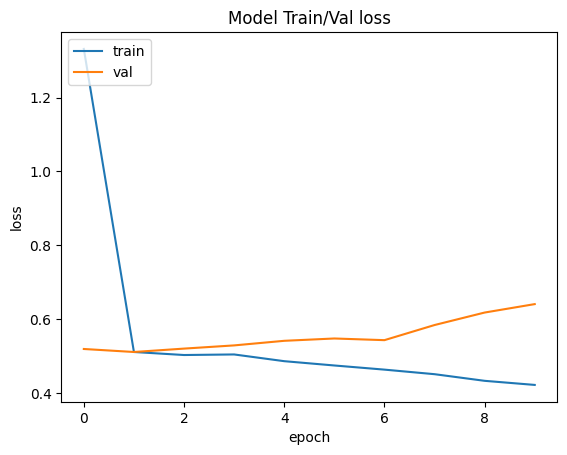

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train/Val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing the Better (2nd) Model

1/1 [==============================] - 0s 25ms/step


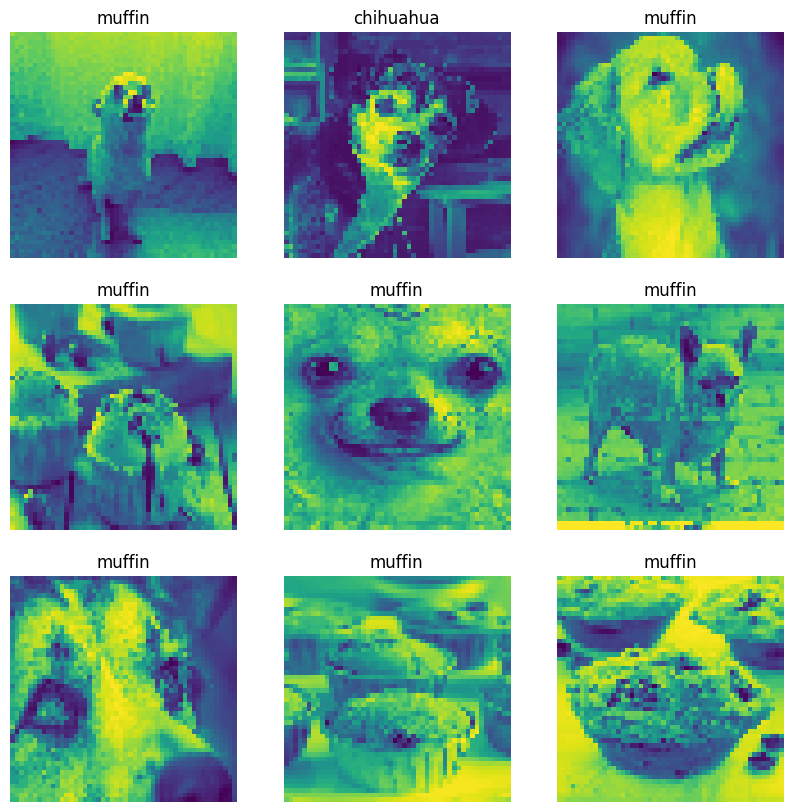

In [51]:
plt.figure(figsize=(10, 10))
for images, labels in ds_val.take(1): #loads batch of 9 images from ds_val
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))

    img = images[i].numpy().astype('uint8')
    img_array = keras.preprocessing.image.img_to_array(img) #convert image to numpy
    img_array = tf.expand_dims(img_array, 0)  #turning single image into array because the model expects an array of images
    predictions = model.predict(img_array) #pushing image into model
    score = predictions[0]
    if score > 0.5:
      plt.title('muffin')
    else:
      plt.title('chihuahua')
    plt.axis("off")

### Accuracy

In [52]:
# check accuracy
test_loss, test_acc = model.evaluate(ds_val, verbose=2)

37/37 - 7s - loss: 0.6407 - accuracy: 0.7912 - 7s/epoch - 201ms/step


## 2ND APPROACH: KNN Model

In [53]:
# separate the images and labels
# for train images
train_img = []
train_label = []
for images, labels in ds_train.map(lambda x, y: (x, y)):
  # print(labels)
  train_label.append(labels)
  train_img.append(images)
train_label = np.concatenate(train_label)
train_label = pd.DataFrame(train_label)
train_label.value_counts()

# for test images
test_img = []
test_label = []

for images, labels in ds_val.map(lambda x, y: (x, y)):
  test_img.append(images)
  test_label.append(labels)
test_label = np.concatenate(test_label)
test_label = pd.DataFrame(test_label)
test_label.value_counts()

1    949
0    234
dtype: int64

In [54]:
# change the image dimensions because knn only takes two dimensions
train_img = np.concatenate(train_img)
nsamples, nx, ny, nrgb = train_img.shape
x_train = train_img.reshape((nsamples,nx*ny*nrgb))

test_img = np.concatenate(test_img)
nsamples, nx, ny, nrgb = test_img.shape
x_test = test_img.reshape((nsamples,nx*ny*nrgb))

### Model Fitting and KNN Metrics

Printed out Classification Report for evaluating KNN metrics

In [55]:
# run the model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
model = model.fit(x_train, train_label[:len(train_img)])

# calculate accuracy
predict = model.predict(x_test)
print(accuracy_score(predict,test_label[:len(predict)]))
print(classification_report(predict,test_label[:len(predict)]))

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7869822485207101
              precision    recall  f1-score   support

           0       0.04      0.25      0.07        36
           1       0.97      0.80      0.88      1147

    accuracy                           0.79      1183
   macro avg       0.51      0.53      0.47      1183
weighted avg       0.94      0.79      0.86      1183

